- make a classifier network that is as similar as possible to the umap subclass

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
from datetime import datetime


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_MOONS, mask_labels

In [7]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MOONS(noise= 0.1, random_state = 1)

In [8]:
labels_per_class = 3
X_labeled, Y_labeled, Y_masked = mask_labels(X_train, Y_train, labels_per_class = labels_per_class)

(2000, 6, 1000)

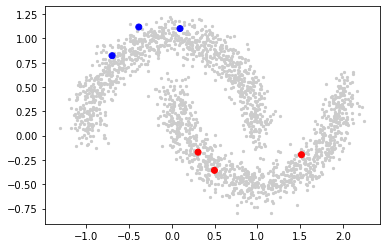

In [9]:
plt.scatter(X_train[:,0], X_train[:,1], color='#CCCCCC', s=5)
plt.scatter(X_labeled[:,0], X_labeled[:,1], c=Y_labeled, cmap = plt.cm.bwr)
len(X_train), len(X_labeled), len(X_valid)

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15 # default = 15
umap_graph = build_fuzzy_simplicial_set(X_train, y= Y_masked, n_neighbors=n_neighbors)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)

In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size)

### Build network

In [17]:
from tensorflow.keras import layers

In [18]:
dims = (2)
num_classes = 2
PROJECTION_DIMS = 2
layer_size = 100

In [19]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.Input(shape=dims))
encoder.add(layers.Dense(layer_size, activation='relu'))
encoder.add(layers.Dense(layer_size, activation='relu'))
encoder.add(layers.Dense(layer_size, activation='relu'))
encoder.add(layers.Dense(layer_size, activation='relu'))

In [20]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.Input(shape=(layer_size)))
classifier.add(layers.Dense(layer_size, activation='relu'))
classifier.add(layers.Dense(num_classes, activation=None, name="predictions"))

In [21]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(layer_size)))
embedder.add(layers.Dense(layer_size, activation='relu'))
embedder.add(layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

### Create UMAP object

In [22]:
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability

In [23]:
from tfumap.semisupervised import find_a_b, compute_umap_loss, compute_classifier_loss

In [31]:
class PUMAP(tf.keras.Model):
    def __init__(
        self,
        encoder,
        embedder,
        classifier,
        tensorboard_logdir=None,  # directory for tensorboard log
        min_dist=0.1,
        negative_sample_rate=5.0,
        optimizer=tf.keras.optimizers.SGD(0.1),
        repulsion_strength=1.0,
        # ** kwargs,
    ):
        super(PUMAP, self).__init__()
        # self.__dict__.update(kwargs)

        # subnetworks
        self.embedder = embedder
        self.encoder = encoder
        self.classifier = classifier

        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.classifier_optimizer = tf.keras.optimizers.Adam(0.01)
        self.repulsion_strength = repulsion_strength
        self.negative_sample_rate = negative_sample_rate

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.create_summary_metrics()

    def create_summary_metrics(self):

        """
        Create keras summary objects for loss
        """
        self.summary_metrics = {}
        self.summary_metrics["train_loss_umap"] = tf.keras.metrics.Mean(
            "train_loss_umap", dtype=tf.float32
        )
        self.summary_metrics["train_loss_classif"] = tf.keras.metrics.Mean(
            "train_loss_classif", dtype=tf.float32
        )
        self.summary_metrics["valid_loss_classif"] = tf.keras.metrics.Mean(
            "valid_loss_classif", dtype=tf.float32
        )
        self.summary_metrics["train_acc_classif"] = tf.keras.metrics.Accuracy(
            "train_acc_classif", dtype=tf.float32
        )
        self.summary_metrics["valid_acc_classif"] = tf.keras.metrics.Accuracy(
            "valid_acc_classif", dtype=tf.float32
        )

    def write_acc(self, X, y, batch, train=True):
        predictions = self.classify_data(X)

        if train:
            summary_writer = self.summary_writer_train
            train_valid = "train"
        else:
            summary_writer = self.summary_writer_valid
            train_valid = "valid"

        self.summary_metrics[train_valid + "_acc_classif"].update_state(predictions, y)

        # write loss
        with summary_writer.as_default():
            tf.summary.scalar(
                "acc_classif",
                self.summary_metrics[train_valid + "_acc_classif"].result(),
                step=batch,
            )
            summary_writer.flush()

    def write_losses(self, batch, classif_loss, umap_loss=None, train=True):
        # add umap loss
        if train:
            summary_writer = self.summary_writer_train
            train_valid = "train"
            self.summary_metrics[train_valid + "_loss_umap"](umap_loss)
        else:
            summary_writer = self.summary_writer_valid
            train_valid = "valid"

        # add valid loss
        self.summary_metrics[train_valid + "_loss_classif"](classif_loss)

        # write loss
        with summary_writer.as_default():
            if train:
                tf.summary.scalar(
                    "umap_loss",
                    self.summary_metrics[train_valid + "_loss_umap"].result(),
                    step=batch,
                )
            tf.summary.scalar(
                "classif_loss",
                self.summary_metrics[train_valid + "_loss_classif"].result(),
                step=batch,
            )
            summary_writer.flush()

    @tf.function
    def train(self, batch_to, batch_from, X, y, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        with tf.GradientTape() as tape:
            (attraction_loss, repellant_loss, umap_loss) = compute_umap_loss(
                batch_to,
                batch_from,
                self.embedder,
                self.encoder,
                self._a,
                self._b,
                self.negative_sample_rate,
                self.repulsion_strength,
            )

            classifier_loss = compute_classifier_loss(
                X, y, self.encoder, self.classifier, self.sparse_ce
            )
            loss = tf.reduce_sum(classifier_loss) + tf.reduce_sum(umap_loss)

        # compute gradient for umap
        grad = tape.gradient(
            loss,
            self.encoder.trainable_variables
            + self.embedder.trainable_variables
            + self.classifier.trainable_variables,
        )

        # gradients are cliped in UMAP implementation. Any effect here?
        grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in grad]

        self.optimizer.apply_gradients(
            zip(
                grad,
                self.encoder.trainable_variables
                + self.embedder.trainable_variables
                + self.classifier.trainable_variables,
            )
        )

        return (attraction_loss, repellant_loss, umap_loss, classifier_loss)

    # @tf.function
    def project_epoch(self, X):
        """ Train a batch in tensorflow
        """
        return [self.embedder(self.encoder(batch)) for batch in X]

    def get_dataset_loss(self, dataset):
        return [
            compute_classifier_loss(X, y, self.encoder, self.classifier, self.sparse_ce)
            for X, y in dataset
        ]

    def classify_data(self, X):
        """ Classify a set of points X
        """
        predictions = self.classifier(self.encoder(X))
        predictions = tf.nn.softmax(predictions)  # .numpy()
        return tf.argmax(predictions, 1)  # predictions[:, 1] - predictions[:, 0]

In [32]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-2), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
)

### plotting results

In [33]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


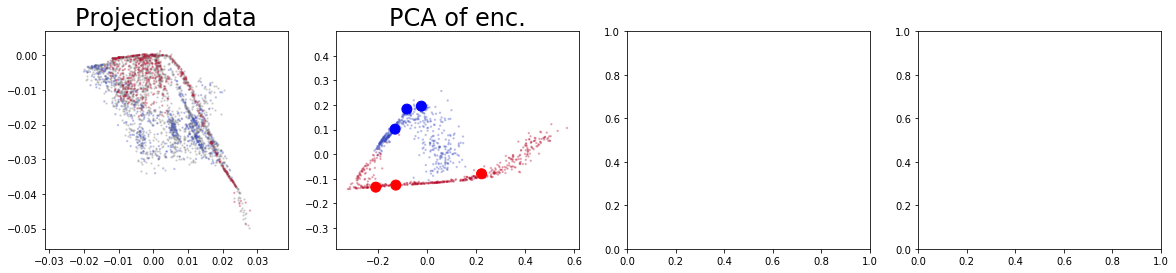

In [34]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size)

### Train model

In [35]:
batch = 0; epoch = 0
N_EPOCHS = 50 # total number of epochs
SAMPLE_EPOCHS = np.linspace(0, N_EPOCHS-1, 10).astype('int') # how often to plot
print(SAMPLE_EPOCHS[:10])
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)
TOTAL_BATCHES = BATCHES_PER_EPOCH * N_EPOCHS

[ 0  5 10 16 21 27 32 38 43 49]


In [36]:
#z_valid = UMAP(verbose=True).fit_transform(latent_valid.numpy())

batch: 0


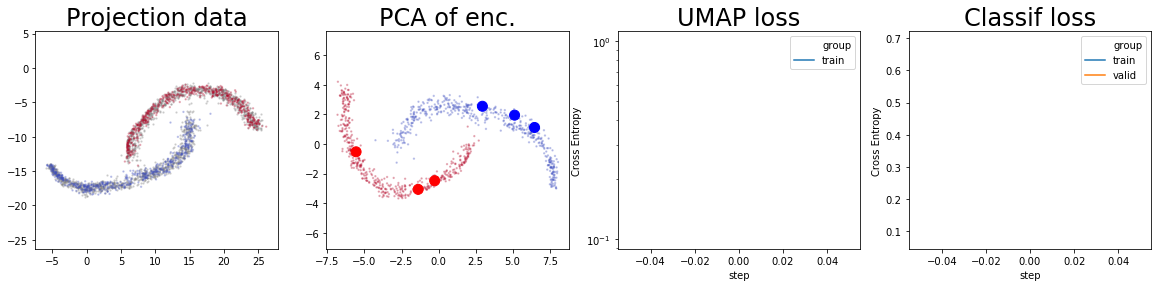

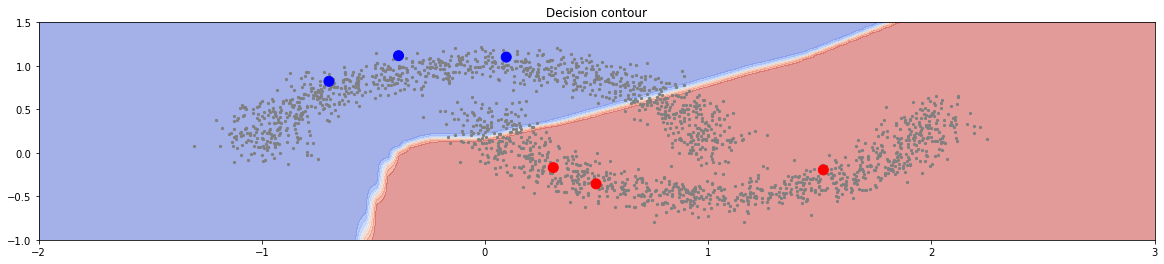

batch: 1960


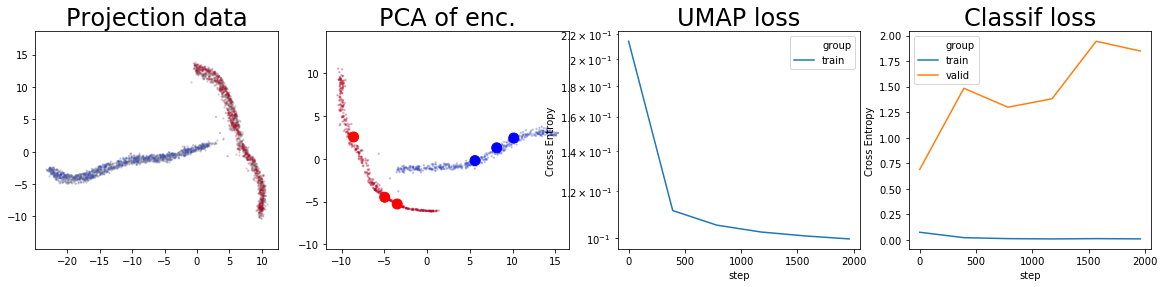

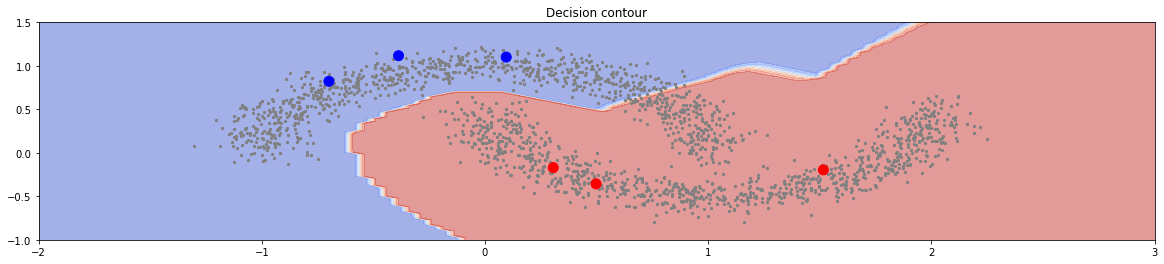

batch: 3920


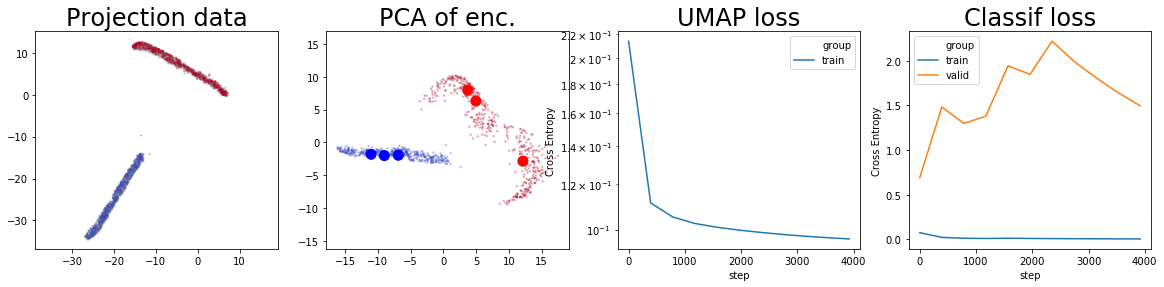

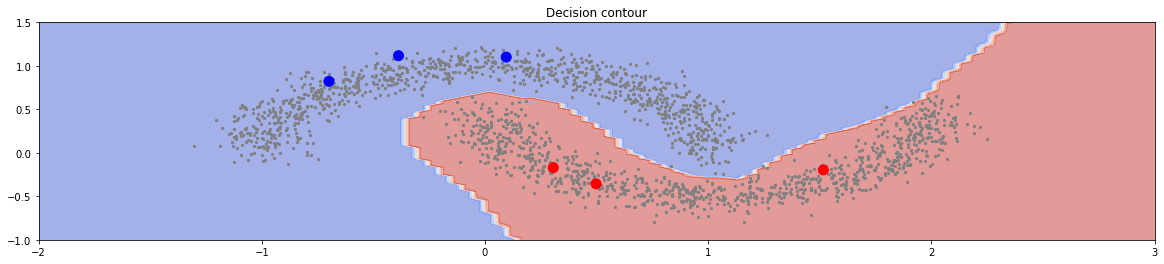

batch: 6272


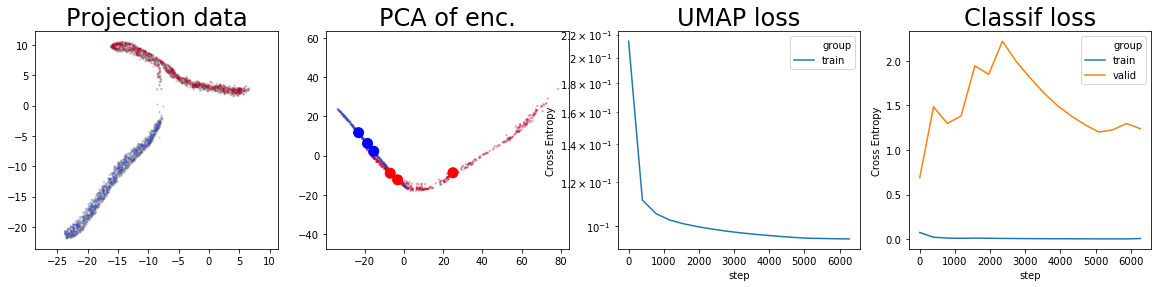

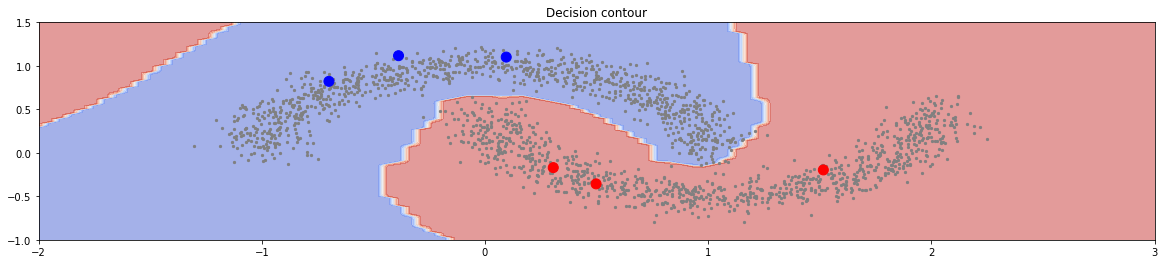

batch: 8232


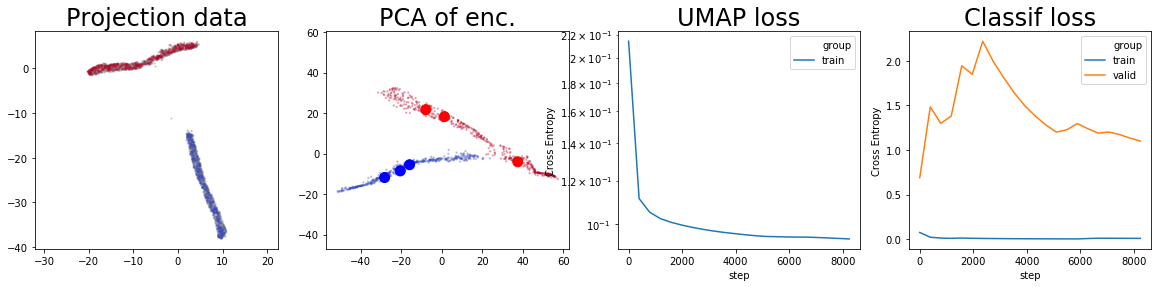

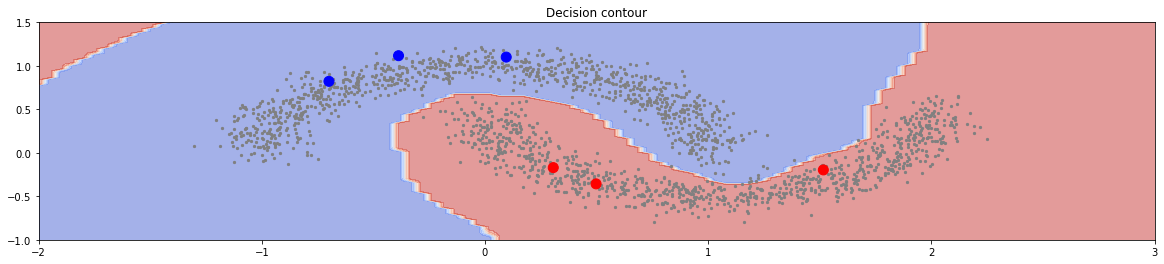

batch: 10584


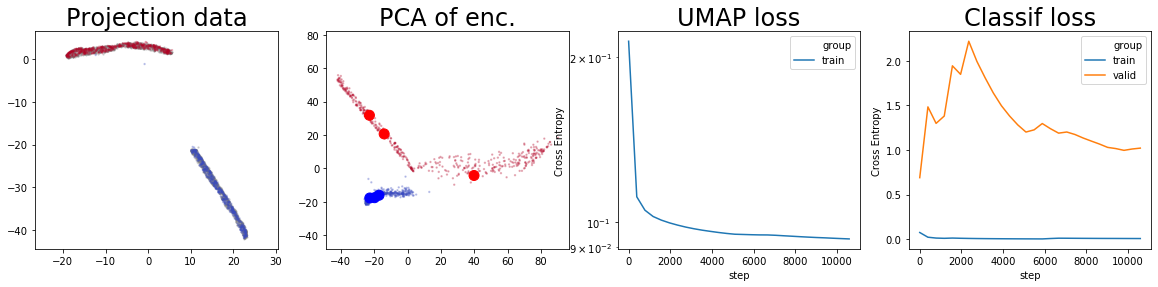

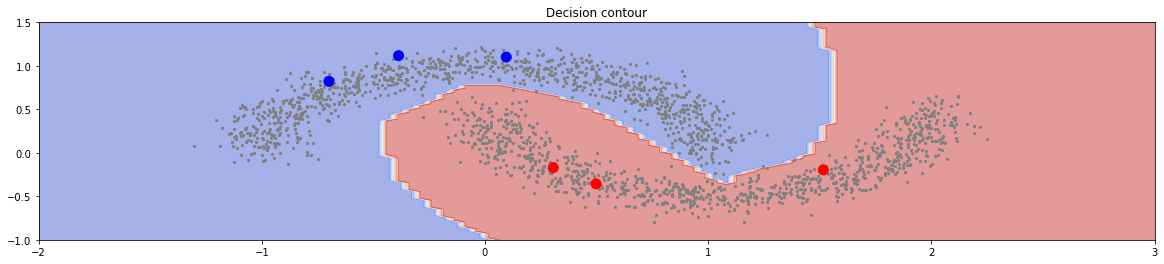

batch: 12544


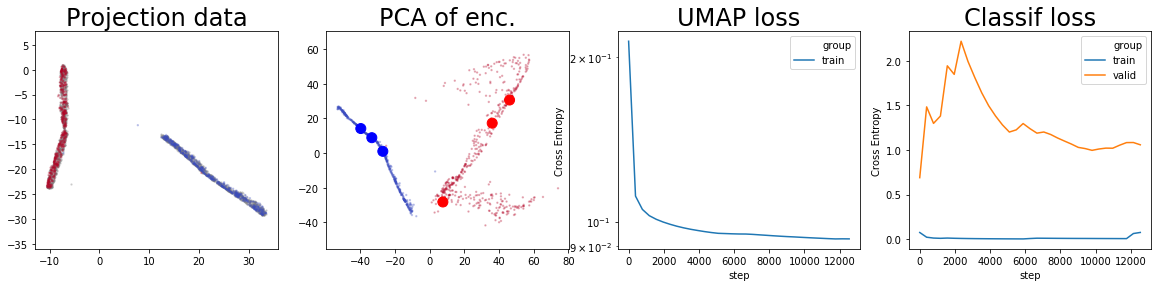

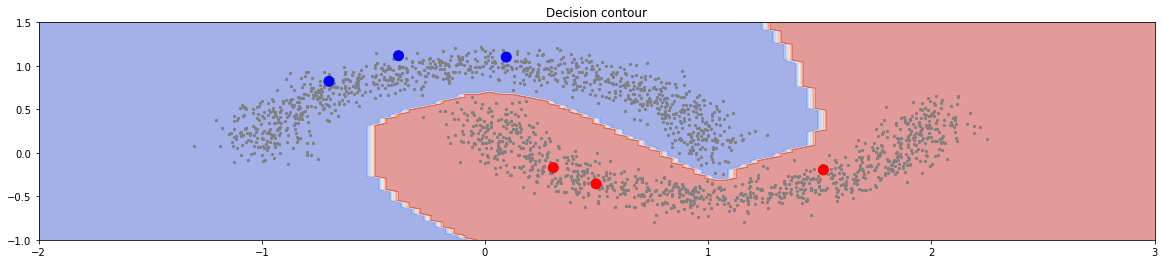

batch: 14896


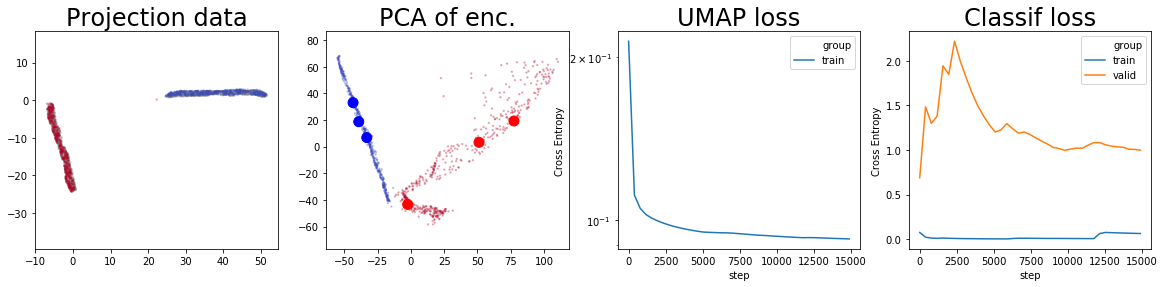

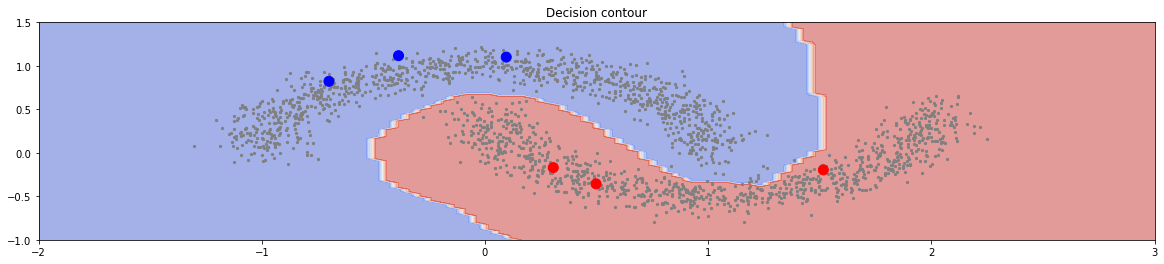

batch: 16856


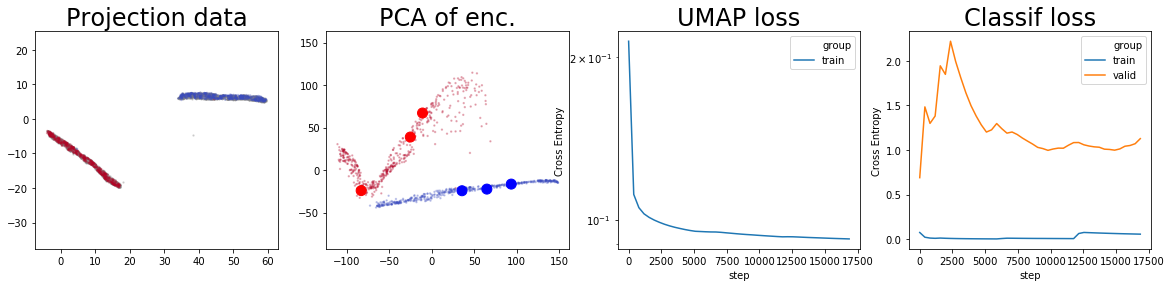

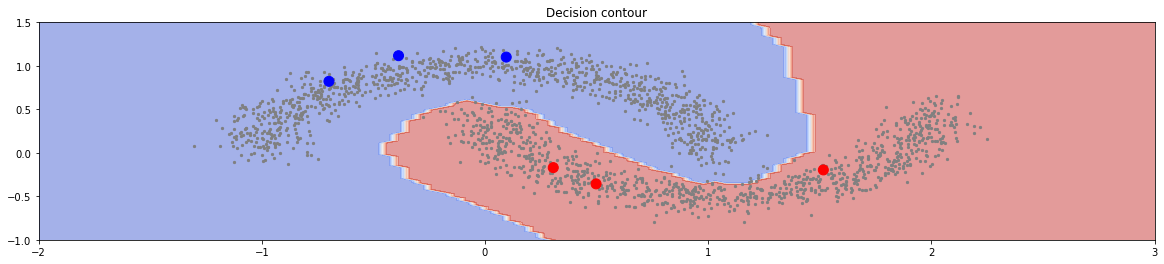

batch: 19208


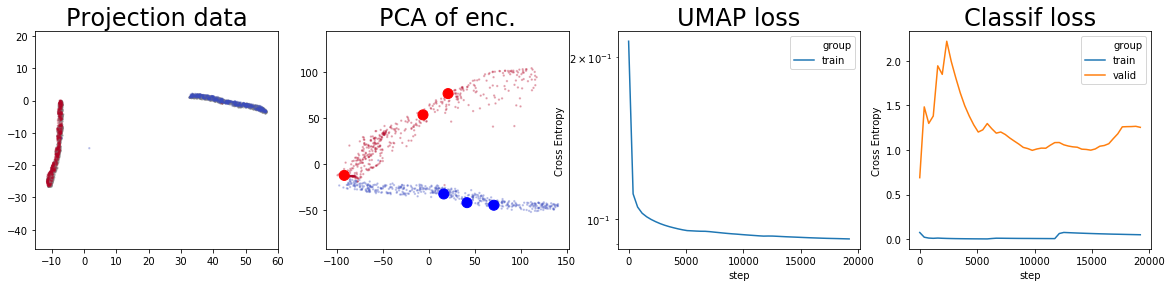

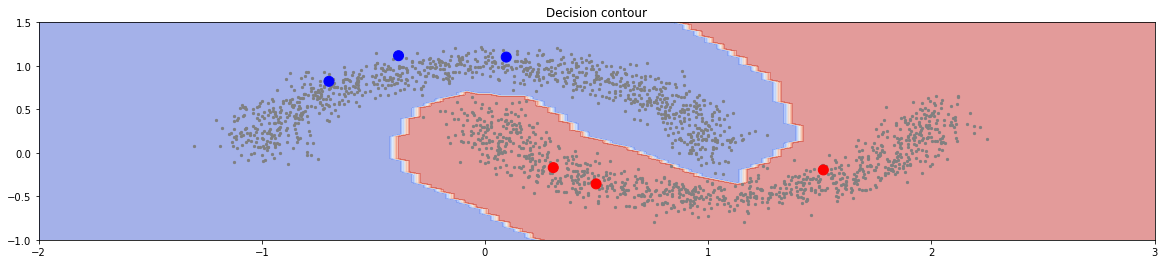

In [37]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    
    # validation loss
    classif_loss = model.get_dataset_loss(data_valid)
    model.write_losses(
            batch=batch, classif_loss=classif_loss, umap_loss=None, train=False
        )
    model.write_acc(X_valid, Y_valid, batch, train=False)
    model.write_acc(X_labeled, Y_labeled, batch, train=True)
    
    # train
    for (batch_to, batch_from), (X, y) in tqdm(
        zip(edge_epoch, labeled_iter), total=BATCHES_PER_EPOCH, leave=False
    ):
        batch_to = X_train[batch_to]
        batch_from = X_train[batch_from]
        # train model
        losses = model.train(batch_to=batch_to, batch_from=batch_from, X=X, y=y)
        model.write_losses(
            batch=batch, classif_loss=losses[3], umap_loss=losses[2], train=True
        )
    # plot
    if epoch in SAMPLE_EPOCHS:
        print("batch: {}".format(batch))
        plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size)
        fig, ax = plt.subplots(ncols=1, figsize=(20,4))
        ax = get_decision_contour(
            ax, model, X_valid, X_train, X_labeled, Y_labeled, samplerate = 100, color="grey", s=5, decision_alpha=0.5#0
        )
        plt.show()
    batch += BATCHES_PER_EPOCH
    # batch_tqdm.update(BATCHES_PER_EPOCH)

In [39]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [40]:
from tfumap.semisupervised_plotting import embed_data

In [41]:
loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

,wall_time,step,val,group,variable
0,1.595868e+09,1,0.500000,train,acc_classif
1,1.595868e+09,393,0.750000,train,acc_classif
2,1.595868e+09,785,0.833333,train,acc_classif
3,1.595868e+09,1177,0.875000,train,acc_classif
4,1.595868e+09,1569,0.900000,train,acc_classif
...,...,...,...,...,...
45,1.595868e+09,17641,0.968304,valid,acc_classif
46,1.595868e+09,18033,0.968936,valid,acc_classif
47,1.595868e+09,18425,0.969562,valid,acc_classif
48,1.595868e+09,18817,0.970143,valid,acc_classif


In [42]:
embedding_valid = embed_data(X_valid, model, batch_size)
embedding_train = embed_data(X_train, model, batch_size)

In [43]:
embedding_labeled = embed_data(X_labeled, model, batch_size)

In [44]:
from tfumap.paths import ensure_dir, save_fig, FIGURE_DIR

In [45]:
sns.set(font='Ariel')
sns.set_style('white')

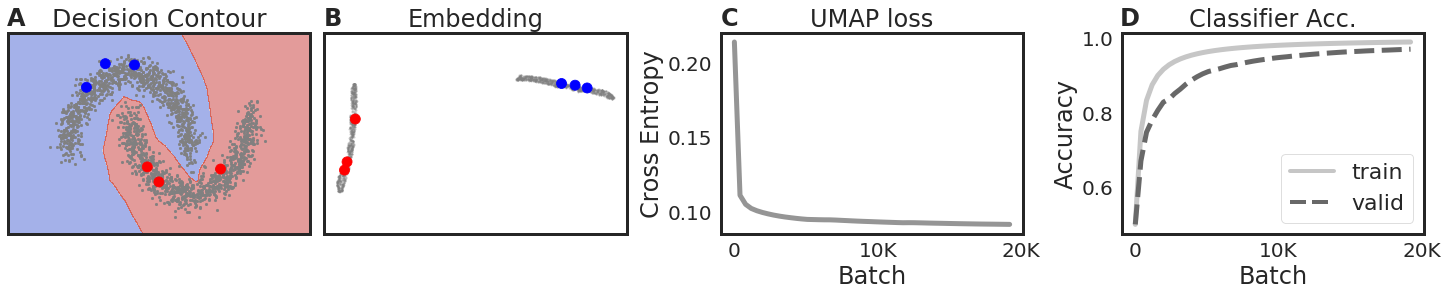

In [48]:
with sns.plotting_context("paper", font_scale=2.5):
    fig, axs = plt.subplots(ncols=4, figsize=(20, 4), constrained_layout=True)
    ax = axs[0]

    ax = get_decision_contour(
        ax,
        model,
        X_valid,
        X_train,
        X_labeled,
        Y_labeled,
        samplerate=1000,
        color="grey",
        s=5,
        decision_alpha=0.5,  # 0
    )
    
    
    
    ax.set_title("Decision Contour", fontsize="25")
    # ax.axis('off')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    ax = axs[1]

    ax.scatter(
        embedding_train[:, 0],
        embedding_train[:, 1],
        c="grey",
        cmap="coolwarm",  # "tab10"
        s=2,
        alpha=0.25,
        rasterized=True,
    )

    ax.scatter(
        embedding_labeled[:, 0],
        embedding_labeled[:, 1],
        c=Y_labeled,
        cmap="bwr",  # "tab10"
        s=100,
        alpha=1,
        rasterized=True,
    )

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    ax.set_title("Embedding", fontsize=24)
    ax.axis("equal")

    ax = axs[2]
    g = sns.lineplot(
        x="step",
        y="val",
        palette = 'Greys',
        hue="group",
        data=loss_df[loss_df.variable == "umap_loss"],
        ci=None,
        ax=ax,
        legend=False,
        lw=5,
    )
    ax.set_title("UMAP loss", fontsize=24)
    ax.set_ylabel("Cross Entropy", fontsize=24)
    ax.set_xlabel("Batch", fontsize=24)
    ax.set_xticks([0, 10000, 20000])
    ax.set_xticklabels(['0', '10K', '20K'])
    # g._legend.remove()
    #ax.set_xscale('log')
    ax = axs[3]
    g = sns.lineplot(
        x="step",
        y="val",
        palette = 'Greys',
        hue="group",
        style='group',
        data=loss_df[loss_df.variable == "acc_classif"],
        ci=None,
        lw=5,
        ax=ax,
        #legend=False,
    )
    ax.set_title("Classifier Acc.", fontsize=24)
    ax.set_ylabel("Accuracy", fontsize=24)
    ax.set_xlabel("Batch", fontsize=24)
    #ax.set_xscale('log')
    #g.legend().set_title('')
    handles, labels = ax.get_legend_handles_labels()
    handles = [copy.copy(ha) for ha in handles ]
    [h.set_linewidth(4) for h in handles]
    ax.legend(handles=handles[1:], labels=labels[1:])
    #ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xticks([0, 10000, 20000])
    ax.set_xticklabels(['0', '10K', '20K'])
    for ax in axs.flatten():
        for axis in ["top", "bottom", "left", "right"]:
            ax.spines[axis].set_linewidth(3)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
    #plt.tight_layout()
    
for ax, label in zip(axs.flatten(), ['A','B','C', 'D']):
    ax.text(0.06, 1.13, label, transform=ax.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')
#plt.subplots_adjust(wspace=0.4)
#plt.tight_layout()
save_fig(FIGURE_DIR/'semisupervised-example-2', save_pdf=True, pad_inches=0.1)